#Tematski modeli

Seminarski rad

Student: Josip Ante Cindrić

Studij: Podatkovna znanost i inženjerstvo

Kolegiji: Strojno učenje

Asistent: Alen Bašić

Profesor: Saša Mladenović

Split, veljača 2022.


##Sažetak

U ovome radu analizirat ćemo tematski model, domenu problema koje model rješava te pristupe rješenja problema metodama strojnog učenja. Navedene metode primijenit ćemo na odabranom podatkovnom skupu kako bi riješili predstavljeni problem i pritom iskoristili algoritme strojnog učenja.

##Uvod

Tematski model(eng. topic model) je statistički model koji služi za pronalazak apstrahiranih "tema" koje se nalaze unutar kolekcije dokumenata. Probabilistički tematski modeli ili samo tematski modeli(eng. topic models) statistički su algoritmi koji pronalaze latentne semantičke strukture unutar tekstualne cjeline. Drugim riječima latentni modeli nam pomažu u organizaciji i razumijevanju velike količine neorganiziranih podataka, generalno teksta.

Ovi algoritmi razvijani su prvenstveno kao alat za rudarenje teksta što ove modele svrstava u područje obrade prirodnog jezika, ali se danas isto tako koriste i u područjima genetike, bio informatike, računalnog vida i analize mreža. Gledajući na ove modele kroz prizmu strojnog učenja valjano je klasificirati ih kao tehnike nenadziranog učenja. U području strojnog učenja razlikujemo i metode "tematske klasifikacije" koje su oblici nadziranog učenja.


##Teorija tematskih modela

Prva tehnika sakupljanja podataka koja je koristila latentne semantičke strukture opisana je i patentirana 1988. godine od strane Deerwestera i suradnika. Iz navedenog istraživanja 1998. godine Papadimitriou i suradnici objavljuju rad pod nazivom "Latentno semantičko indeksiranje: Probabilistička analiza"(eng. Latent semantic indexing: A probabilistic analysis) u kojem postavljaju matematičku bazu za do tada empirički uspješnu, ali u striktno matematičkom smislu nerigorozno definiranu tehniku. Objavom tog rada definiran je prvi tematski model iako je tehnika korištena u području sakupljanja podataka unatrag deset godina sa velikim uspjehom. Ovu tehniku nazivamo "Latentna semantička analiza" ili "Latentno semantičko indeksiranje" tj. skraćeno LSA ili LSI. Ova metoda koristi dekompoziciju po singularnim vrijednostima(eng. Singular value decomposition) ili skraćeno SVD kako bi identificirala veze između riječi sadržane u nestrukturiranom tekstu.

Već sljedeće godine Thomas Hofmann objavljuje rad pod nazivom "Probabilistička latentna semantička analiza"(eng. Probabilistic Latent Semantic Analysis) u kojem opisuje novu statističku metodu namijenjenu analizi bimodalnih podataka u semantičkoj mreži. Jednostavnije PLSA tj. PLSI je metoda koja je evoluirala iz LSA metode te je pri tome generaliziran pristup problemu uz "jaču" bazu u statistici. Za razliku od prijašnje metode PLSI koristi miješanu dekompoziciju deriviranu iz modela latentnih klasa.

2002 . godine Blei i suradnici objavljuju do danas vjerojatno najkorišteniji tematski model koji je dakako generalizacija PLSA modela. Latentna Dirichletova alokacija(eng. Latent Dirichlet allocation) je generativna statistička metoda koja objašnjava kako skup promatranih objekata povezuje sličnost među podacima preko latentnih grupa. Na primjer, pretpostavimo da su promatrani objekti riječi u nekom tekstu, LDA tvrdi da je svaki tekst mješavina određenog broja tema i da je prisutnost svake riječi u tekstu dodjeljiva određenoj temi. 

Alternative LDA metodi su Hijerarhijska analiza latentnih stabala(eng. Hierarchical Latent Tree Analysis) skraćeno HLTA, Nenegativna faktorizacija matrica(eng. Non-negative matrix factorization) skraćeno NMF te Stohastički blok model(eng. Stochastic block model).


##O podatkovnom skupu


Odabrani podatkovni skup kroz dvije datoteke modelira znanstvene radove za koje znamo naslove, sažetak i tematiku pod koje možemo svrstati iste. Dane znanstvene radove možemo svrstati u više tematskih kategorija koje obuhvaćaju:

*   Računarstvo(eng. Computer Science)

*   Fiziku(eng. Physics)

*   Matematiku(eng. Mathematics)

*   Statistiku(eng. Statistics)

*   Kvantitativnu biologiju(eng. Quantitative Biology)

*   Kvantitativne financije(eng. Quantitative Finance)

Za potrebe modela koje proučavamo u ovome radu ove kategorije nisu bitne pošto su one target varijable za metode tematske klasifikacije.

##Eksplorativna analiza podataka

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML/projekt_topic_model

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

Odabrani skup podataka ćemo učitati iz CSV formata u Pandas DataFrame.

In [4]:
articles_train = pd.read_csv('train.csv')
articles_test = pd.read_csv('test.csv')

Nakon što smo podatke učitali valja pogledati s kakvim podacima raspolažemo.

In [5]:
articles_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


 Članaka ukupno ima 20972 od koji svi imaju:
*   "ID" u ulozi jedinstvenog identifikatora
*   "TITLE" odnosno naslov znanstvenog rada
*   "ABSTRACT" tj. sažetak znanstvenog rada
*   ostale stupce koji definiraju tematiku znanstvenog rada - ciljane varijable(eng. target variable)

Target varijable smo slobodni ukloniti iz skupa podataka.


In [6]:
articles_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        8989 non-null   int64 
 1   TITLE     8989 non-null   object
 2   ABSTRACT  8989 non-null   object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


Kao što možemo vidjeti test datoteka je drugačije koncipirana od train datoteke time što su podaci o tematici pohranjenih radova izostavljeni. Ova činjenica  ovu datoteku čini neiskoristivom za algoritme klasifikacije pošto nemamo na čemu ocijeniti izlaz treniranog modela tj. nemamo target varijablu. Nakon što uklonimo target varijable iz prve tablice možemo ih samo spojiti.

Podatkovni skup je jednostavno optimiziran u DataFrame zapisu pravilno dodijeljenim tipovima podataka stupcima. Dodatna optimizacija algoritma može se postići indeksiranjem po "ID" stupcu te kreiranjem sparse matrice radi stupaca koji označavaju tematiku radova za slučaj klasifikacije.

Nakon što smo sagledali kojim podacima raspolažemo možemo ih prikazati u tabličnom obliku kako bi dobili bolji osjećaj za tip podataka s kojim raspolažemo.


In [7]:
articles_train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


Kako smo već spomenuli optimizaciju indeksiranja tablice po "ID" stupcu ovakvim prikazom vidimo da je sam stupac efektivno nepotreban pošto je index isti niz preslikan linearnom funkcijom $f(x)=x+1$ tako da stupac "ID" možemo jednostavno ukloniti.

Radi konvencija zapisa varijabli u Pythonu preimenovati ćemo preostale stupce te samu tablicu.

In [8]:
articles_train.drop(labels=['ID'], axis=1, inplace=True)
articles_test.drop(labels=['ID'], axis=1, inplace=True)

Uređenjem tablice spremni smo vizualizirati podatke koje imamo.

In [9]:
articles_train.iloc[:,2:].sum()

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64

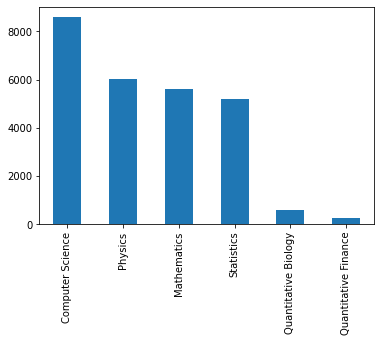

In [10]:
articles_train.iloc[:,2:].sum().plot(kind='bar')

Kao što vidimo u uzorku se nalazi relativno malo članaka kvantitativne biologije i kvantitativnih financija dok su članci preostalih tematskih klasa poprilično zastupljeni u uzorku. Bitno je naglasiti kako članak može spadati u više tematskih kategorija.

In [11]:
articles = pd.concat([articles_train.iloc[:,:2], articles_test])
articles.columns = ['title', 'abstract']
articles

,title,abstract
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...
...,...,...
8984,Supporting mixed-datatype matrix multiplicatio...,We approach the problem of implementing mixe...
8985,An axiomatic basis for Blackwell optimality,In the theory of Markov decision processes (...
8986,GeneVis - An interactive visualization tool fo...,GeneVis is a web-based tool to visualize com...
8987,Quantifying the causal effect of speed cameras...,This paper quantifies the effect of speed ca...


##Primjena tematskih modela

Na prikazanom podatkovnom skupu prikazat ćemo LSI i LDA koristeći implementacije iz "Gensim" modula. Genism modul je najspecijaliziranija Python biblioteka za tematske modele sa optimiziranim implementacija većine relevantnih algoritama u području tematskog modeliranja.

Osnovni koncepti na kojima je zasnovan Gensim su:
*   Dokument: tekstualni zapis("str" podatak u Pythonu 3)
*   Korpus: kolekcija dokumenata
*   Vektor: matematička reprezentacija dokumenta
*   Model: algoritam koji mijenjaju reprezentacije vektora

###Dokument

Dokument možemo reprezentirati kako god želimo za potrebe modela, od jedne rečenice do cijele knjige.

In [12]:
document = "Human machine interface for lab abc computer applications"
document

'Human machine interface for lab abc computer applications'

###Korpus

Korpus(eng. corpus, pl. corpora) je jednostavno kolekcija dokumenata. Po funkciji korpuse dijelimo na:

*   Ulazne objekte za treniranje modela
*   Objekte na kojima koristimo trenirani model

u sljedećem primjeru vidimo korpus od 9 dokumenata što je izrazito maleno za standarde obje navedene klasifikacije.


In [13]:
corpus = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

corpus

['Human machine interface for lab abc computer applications',
 'A survey of user opinion of computer system response time',
 'The EPS user interface management system',
 'System and human system engineering testing of EPS',
 'Relation of user perceived response time to error measurement',
 'The generation of random binary unordered trees',
 'The intersection graph of paths in trees',
 'Graph minors IV Widths of trees and well quasi ordering',
 'Graph minors A survey']

###Prilagodbena obrada podataka

Prilagodbena obrada korpusa bitna je stavka treniranja svakog modela pošto želimo prilagoditi podatke matematičkim algoritmima za efikasniju obradu. Postoje brojne metode koje se primjenjuju u prilagodbenoj obradi teksta koje ćemo detaljnije obraditi u kasnijim poglavljima.

U svrhu prikazivanja jednostavne obrade prikazat ćemo jednostavnu tokenizaciju korpusa te kreiranje rječnika.

Ideja tokenizacije je jednostavno rastavljanje teksta na riječi tj. tokene. Prije nego to učinimo definiramo skup riječi koje ne želimo indeksirati. Te riječi nazivamo stop riječima(eng. stop words) te ih definiramo ovisno o jeziku kojeg analiziramo. Specifično za engleski jezik mnoge riječi poput "the", "of" ili "and" možemo definirati kao semantički neutralne sa većinski gramatičkom svrhom. Evidentno je da radi navedenog svojstva one nisu potrebne u semantičkoj analizi.


In [14]:
stopwords = set('for a of the and to in'.split(' '))
processed_corpus = [[word for word in document.lower().split() if word not in stopwords] for document in corpus]

processed_corpus

[['human', 'machine', 'interface', 'lab', 'abc', 'computer', 'applications'],
 ['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'management', 'system'],
 ['system', 'human', 'system', 'engineering', 'testing', 'eps'],
 ['relation', 'user', 'perceived', 'response', 'time', 'error', 'measurement'],
 ['generation', 'random', 'binary', 'unordered', 'trees'],
 ['intersection', 'graph', 'paths', 'trees'],
 ['graph', 'minors', 'iv', 'widths', 'trees', 'well', 'quasi', 'ordering'],
 ['graph', 'minors', 'survey']]

Kao što možemo vidjeti dobili smo tokeniziran korpus, svaki dokument u korpusu više nije jedna tekstualna instanca već je kolekcija istih.

Sa ovakvom tokenizacijom bi potencijalno mogli završiti prilagodbenu obradu, ali možemo primijeniti još jednu metodu kako bi poboljšali rezultate algoritma, a ta metoda je filtriranje tokena unutar dokumenata po količini pojavljivanja unutar korpusa. Na taj način donekle možemo osigurati relevantnost tokena koje dajemo modelu na analizu. U protivnom, model bi efektivno bio zagušen nepotrebnim podacima tj. slikovito kao da čovjek traži iglu u plastu sijena.


In [15]:
filter_threshold = 1
frequency = defaultdict(int)

for text in processed_corpus:
    for token in text:
        frequency[token] += 1

processed_corpus = [[token for token in text if frequency[token] > filter_threshold] for text in processed_corpus]
processed_corpus

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

Vidimo da se ovaj tokenizirani korpus sadržava manje tokena od prošloga što smo i očekivali. Jedino što nam ostaje je kreirati rječnik za naš korpus koji definira sve riječi koje naš korpus sadrži.

In [16]:
dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)


###Vektor

Kako bi matematički izveli latentnu strukturu promatranog korpusa trebamo matematički prikazati dokumente u korpusu kako bi njima mogli upravljati. U praksi se mogu pronaći dva pristupa:

*   Dokument kao vektor značajki
*   Dokument kao "bag-of-words" model

Značajke u prvoj klasi npr. možemo smatrati parom pitanja i odgovora, gdje je primjer reprezentacije nekog proizvoljnog dokumenta kroz dva pitanja jednak: $(1,2), (2, 0.0)$. Ovakav tip vektora nazivamo potpunim tj. gustim vektorom(eng. dense vector) pošto sadrži odgovor na svako pitanje iz skupa pitanja.

"Bag-of-words" tj. BoW model je model iz klase modela vektorskog prostora tj. VSM modela(eng. Vector Space Model). To su algebarski modeli koji reprezentiraju tekstualne dokumente kao vektore značajki. Iz navedenog je lako zaključiti da je VSM generalizacija oba navedena pristupa. BoW model tekst reprezentira kao multiskup(eng. bag, multiset) riječi, gdje zanemaruje raspored ili veze među riječima dok zadržava višestrukost elemenata. Kako bi efikasno primijenili BoW model bitno je obraditi tekst prije nego ga proslijedimo modelu.

Naš obrađeni korpus sadrži 12 jedinstvenih riječi što implicira da će BoW vektorska reprezentacija sadržavati 12 dimenzija. Kreirani rječnik koristimo za transformirati tokenizirane dokumente u 12-dimenzionalne BoW vektore.

Npr. Prikazati ćemo frazu "Human computer interaction" koja nije dio našeg korpusa u obliku BoW vektora.


In [17]:
dictionary.token2id

{'computer': 0,
 'eps': 8,
 'graph': 10,
 'human': 1,
 'interface': 2,
 'minors': 11,
 'response': 3,
 'survey': 4,
 'system': 5,
 'time': 6,
 'trees': 9,
 'user': 7}

In [18]:
new_document = "Human computer interaction"
new_vector = dictionary.doc2bow(new_document.lower().split())
new_vector

[(0, 1), (1, 1)]

U ovom prikazu vektora prikazana su dva para koordinata, gdje je prva koordinata jedinstveni identifikator riječi u rječniku, a druga koordinata broj pojavljivanja riječi u dokumentu. Kao što vidimo riječ "interaction" se ne nalazi u vektoru pošto se ne pojavljuje u rječniku.

Na isti način možemo pretvoriti originalni korpus u kolekciju BoW vektora.

In [19]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
bow_corpus

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]

### Model

Nakon što smo vektorizirali dati korpus možemo na njemu primijeniti različite modele za različite transformativne svrhe. Primjer jednostavnog modela je "tf-idf"(eng. abbr. term frequency–inverse document frequency) model koji je statistika koja govori koliko je koja riječ u dokumentu važna za taj dokument u korpusu. Efektivno, ovaj model transformira BoW vektor u vektor kojemu je broj pojavljivanja riječi težinski normiran prema učestalosti svake riječi u korpusu.

Npr. prikazat ćemo kako funkcionira tf-idf model na kratkom dokumentima "Human computer interaction" i "system minors".


In [20]:
tfidf_model = models.TfidfModel(bow_corpus)

words = "system minors".lower().split()
print(tfidf_model[dictionary.doc2bow(words)])

words = "Human computer interaction".lower().split()
print(tfidf_model[dictionary.doc2bow(words)])

[(5, 0.5898341626740045), (11, 0.8075244024440723)]
[(0, 0.7071067811865476), (1, 0.7071067811865476)]


Nakon kreacije modela možemo ga koristiti za razne stvari tj. specifično tf-idf modelu možemo transformirati i indeksirati cijeli korpus te nad njime obavljati upite. Npr. možemo provjeriti koliko je neki dokument sličan dokumentima u našem korpusu.

In [21]:
index = similarities.SparseMatrixSimilarity(tfidf_model[bow_corpus], num_features=12)
query_document = 'system engineering'.split()
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf_model[query_bow]]
list(enumerate(sims))

[(0, 0.0),
 (1, 0.32448703),
 (2, 0.41707572),
 (3, 0.7184812),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0)]

##Primjer izrade tematskih modela

###Prilagodbena obrada korpusa

Prilagodbena obrada korpusa znatno je kompliciranija nego što je prikazana u prijašnjem primjeru. Argument za klasificiranje tematskih modela pod algoritme obrade prirodnog jezika prvenstveno dolazi iz ovog stadija pripreme podataka gdje se primjenjuju znanja i tehnike kako bi se što kvalitetnije vektorizirao korpus.

Prije nego se upustimo u prilagodbenu obradu korpusa potrebno je prvo kreirati korpus. Prilagodba ovom specifičnom skupu podataka zahtjeva da uklonimo sve LATEX izraze iz korpusa što je prikladno napraviti pri kreaciji.

In [22]:
corpus = [re.sub(r'\$.*?\$', "", document) for document in list(articles.title.values + articles.abstract.values)]
 
corpus[:10]

["Reconstructing Subject-Specific Effect Maps  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used 

Prvi korak prilagodbene obrade korpusa je tokenizacija teksta. Tokenizacija, kao što smo već naveli, je metoda obrade teksta koja od tekstualne cjeline stvara kolekciju tokena tj. razdvaja tekst na "riječi". Detaljno objašnjenje tokenizacije za ovaj rad je nepotrebno, već je samo bitno napomenuti kako je za potrebe tematskih modela tokenizacija regularnim izrazima(eng. regular expression tokenization) jedna od prikladnih opcija.

"Regex" tokenizacija kao predložak po kojemu kreira tokene uzima dani regularni izraz te po njemu odvaja tekstualne cjeline. U izvedbi danu tokenizaciju možemo vidjeti u sljedećem primjeru. Za regularni izraz uzimamo sve riječi koje imaju u sebi slova te rastavljamo riječi koje u sebi imaju interpunkcijske znakove poput apostrofa ili crte.


In [23]:
regex = r"(?u)[\b\#a-zA-Z]+\b"
tokenizer = RegexpTokenizer(regex)
corpus_tokenized = [tokenizer.tokenize(document) for document in corpus]
corpus_tokenized[0][:20]

['Reconstructing',
 'Subject',
 'Specific',
 'Effect',
 'Maps',
 'Predictive',
 'models',
 'allow',
 'subject',
 'specific',
 'inference',
 'when',
 'analyzing',
 'disease',
 'related',
 'alterations',
 'in',
 'neuroimaging',
 'data',
 'Given']

Nakon tokenizacije spremni smo ukloniti stop riječi iz korpusa. U ovome primjeru koristit ćemo kolekciju stop riječi iz nltk biblioteke. Alternative postoje, ali niti jedna kolekcija nije savršeno prikladna za svaki korpus. Kreacija kolekcije stop riječi svojstvena je svakom korpusu zasebno. Jedna od metoda za kreaciju potpunije kolekcije je analiza najfrekventnijih riječi u korpusu, ali to je van opsega ovoga rada. Uz filtriranje stop riječi uklonit ćemo i sve tokene koji su kraći od 3 slova uz pretpostavku da su semantički manje važni.

In [25]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
stop_words = set(stopwords.words('english')).union({'us'})

processed_corpus = [[token for token in document if token.lower() not in stop_words and len(token) > 2] for document in corpus_tokenized]
processed_corpus[0][:20]

['Reconstructing',
 'Subject',
 'Specific',
 'Effect',
 'Maps',
 'Predictive',
 'models',
 'allow',
 'subject',
 'specific',
 'inference',
 'analyzing',
 'disease',
 'related',
 'alterations',
 'neuroimaging',
 'data',
 'Given',
 'subject',
 'data']

Nakon što smo izbacili stop riječi iz korpusa možemo analizirati korpus za moguće neposredne odnose između tokena. Takve tokene zovemo n-gramima koje definiramo kao sekvencu od $n$ susjednih tokena. Razlog grupacije tokena u n-grame jest što zasebno neki tokeni nisu semantički značajni dok skupa, u obliku n-grama, potencijalno mogu biti. Radi jednostavnosti za naš primjer analizirati ćemo samo bigrame.

In [27]:
bigram = gensim.models.Phrases(processed_corpus, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
processed_corpus = [bigram_mod[document] for document in processed_corpus]

In [28]:
[[token for token in document if '_' in token] for document in processed_corpus][:3]

[['widely_used',
  'Maximum_Posteriori',
  'Alzheimer_Disease',
  'Neuroimaging_Initiative',
  'Alzheimer_Disease'],
 ['Neural_Network',
  'convolutional_neural',
  'position_orientation',
  'Last_least'],
 ['spherical_harmonics']]

Nakon potpune tokenizacije obrada može nastaviti obradom kreiranih tokena što je generalno dobra praksa. U obradi prirodnog jezika razlikujemo dvije metode obrade jednostavnih tokena:

*   Analiza korijenskog morfema(eng. stemming)
*   Analiza leksema(eng. lemmatization)

U morfologiji svaka riječ se sastoji od najmanjih jedinica koje imaju svoje značenje. Njih nazivamo morfemima. Npr. u hrvatskom jeziku nominativ imenice "slika" ima morfeme "slik-" i "-a". gdje je korijenski morfem "slik-". Proces analize korijenskog morfema bi u ovom slučaju bi token "slika" zamijenio sa njegovim korijenskim morfemom "slik".

Leksemi s druge strane su riječi sa ukupnošću svojih oblika. Npr. leksem "slika" podrazumijeva imenicu "slika" u oba broja i svim padežima. Time bi proces analize leksema riječ "slikama" zamijenio leksemom "slika".

U praksi prilagodbene obrade korpusa analiza leksema se generalno više preferira od alternativnih metoda. Gotovih rješenja za navedene analize u Pythonu ima mnogo, a mi ćemo iskoristiti gotovo rješenje iz nltk modula pod nazivom "WordNetLemmatizer".


In [29]:
lemmatizer = WordNetLemmatizer()
processed_corpus = [[lemmatizer.lemmatize(token) for token in document] for document in processed_corpus]

In [30]:
processed_corpus[1][:20]

['Rotation',
 'Invariance',
 'Neural_Network',
 'Rotation',
 'invariance',
 'translation',
 'invariance',
 'great',
 'value',
 'image',
 'recognition',
 'task',
 'paper',
 'bring',
 'new',
 'architecture',
 'convolutional_neural',
 'network',
 'CNN',
 'named']

Ovom analizom smo finalizirali prilagodbenu obradu korpusa za potrebe ovog rada. U slučaju izrade sekvencijalne obrade(eng. pipeline) za produkcijsko okruženje trenutnom infrastrukturom bi se rijetko tko zadovoljio, ali za potrebe izlaganja seminarskog rada prikazali smo većinu relevantnih metoda u primjeni prilagodbene obrade korpusa.

###Kreacija tematskih modela

Spremni smo pripremiti korpus za kreiranje tematskog modela. Kreirati ćemo rječnik obrađenog korpusa, te vektorizirati korpus BoW modelom. Kako bi dodatno prilagodili korpus modelu filtrirati ćemo riječi iz rječnika koje se pojavljuju ispod 20 puta i u preko 50% dokumenata.

In [31]:
dictionary = corpora.Dictionary(processed_corpus)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus_vectorized = [dictionary.doc2bow(document) for document in processed_corpus]

In [32]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus_vectorized))

Number of unique tokens: 9229
Number of documents: 29961


Nakon kreacije rječnika i vektorizacije korpusa spremni smo za kreaciju modela. Kao primjer uzeti ćemo LSI model.
LSI model kao obavezne parametre prima vektorizirani korpus i rječnik. Kao opcionalne među ostalom prima broj tema.

In [33]:
lsi_model = LsiModel(corpus_vectorized, id2word = dictionary)

In [34]:
lsi_model.print_topics(num_topics=5, num_words=10)

[(0,
  '0.377*"model" + 0.239*"data" + 0.224*"method" + 0.179*"network" + 0.169*"problem" + 0.164*"based" + 0.161*"algorithm" + 0.160*"system" + 0.146*"time" + 0.145*"result"'),
 (1,
  '-0.854*"model" + 0.238*"problem" + 0.234*"algorithm" + 0.136*"method" + 0.090*"system" + 0.084*"time" + 0.083*"function" + 0.079*"result" + 0.075*"graph" + 0.071*"solution"'),
 (2,
  '-0.438*"network" + -0.355*"data" + 0.292*"system" + -0.202*"method" + -0.173*"learning" + 0.146*"state" + -0.125*"algorithm" + 0.122*"energy" + 0.117*"field" + 0.112*"two"'),
 (3,
  '0.776*"network" + -0.420*"data" + -0.215*"method" + 0.164*"system" + -0.153*"algorithm" + 0.103*"node" + -0.101*"problem" + 0.071*"state" + 0.069*"structure" + 0.067*"dynamic"'),
 (4,
  '0.495*"data" + -0.409*"problem" + -0.402*"algorithm" + 0.324*"system" + -0.274*"model" + -0.154*"graph" + -0.100*"function" + -0.078*"optimization" + -0.075*"solution" + 0.070*"using"')]

Način na koji vrednujemo tematske modele je pomoću modela koherencije(eng. Coherence Model) čiju implementaciju pronalazimo u gensimu.

In [35]:
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=processed_corpus, coherence='c_v')

In [36]:
coherence_model_lsi.get_coherence()

0.21365528843780726

Trenutno trenirani model je ocjenjen poprilično loše. U ovom slučaju iterativnom metodom bi probali testirati hiperparametre poput "no_below" ili "no_above" u metodi "filter_extremes" te prvenstveno "num_topics" pri treniranju modela.

In [37]:
def create_lsi_model(corpus, dictionary, no_topics):
    model = LsiModel(corpus, num_topics=no_topics, id2word = dictionary)
    return model

def get_lsi_coherence_list(corpus_vectorized, dictionary, no_topics_list, processed_corpus):
  model_cv = []
  for no_topics in no_topics_list:
      model = create_lsi_model(corpus_vectorized, dictionary, no_topics)
      coherencemodel = CoherenceModel(model=model, texts=processed_corpus, dictionary=dictionary, coherence='c_v')
      model_cv.append((model, coherencemodel.get_coherence()))
  return model_cv

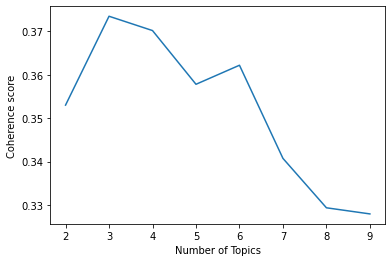

In [38]:
x = range(2, 10)
lsi_model_cv = get_lsi_coherence_list(corpus_vectorized, dictionary, x, processed_corpus)
plt.plot(x, [value[1] for value in lsi_model_cv])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

Kao što možemo vidjeti na grafu najbolje ocjenjen model je model koji projicira 3 teme.

In [50]:
lsi_model_cv[1][0].print_topics()

[(0,
  '0.377*"model" + 0.239*"data" + 0.224*"method" + 0.179*"network" + 0.169*"problem" + 0.163*"based" + 0.160*"algorithm" + 0.160*"system" + 0.146*"time" + 0.145*"result"'),
 (1,
  '-0.854*"model" + 0.238*"problem" + 0.236*"algorithm" + 0.139*"method" + 0.085*"system" + 0.083*"time" + 0.082*"function" + 0.078*"result" + 0.076*"graph" + 0.070*"solution"'),
 (2,
  '-0.458*"network" + -0.347*"data" + 0.289*"system" + -0.197*"method" + -0.171*"learning" + 0.144*"state" + 0.122*"energy" + -0.118*"algorithm" + 0.118*"field" + 0.111*"two"')]

In [51]:
coherence_model_lsi = CoherenceModel(model=lsi_model_cv[1][0], texts=processed_corpus, coherence='c_v')

In [52]:
coherence_model_lsi.get_coherence()

0.37343408395725847

Računajući da najveća količina dokumenata u korpusu pripada radovima tematike računarstva rezultati nisu pretjerano začuđujući.

Pošto smo pokazali funkcionalnost LSI modela preostaje nam još LDA model.

In [42]:
lda_model = LdaModel(
    corpus=corpus_vectorized,
    id2word=dictionary,
    chunksize=2000,
    alpha='auto',
    eta='auto',
    iterations=400,
    num_topics=4,
    passes=20,
    eval_every=None)

Odabir hiperparametara u relevantnih LDA modelu puno je veći nego kod LSI modela. Opcionalni parametri koji poboljšavaju rezultate modela su "passes", "iterations" i "chunksize". "alpha" i "beta" su parametri reprezentiraju gustoću distribucije tema u dokumentu tj. riječi po temama. Kada alpha i beta poprime vrijednost 1 postižemo pLSA model. Parametar "eval_every" je postavljen na "None" prema savjetu dokumentacije. Ostalo je identično kao i kod LSI modela.

In [43]:
top_topics = lda_model.top_topics(corpus_vectorized, topn=10)

In [44]:
top_topics

[([(0.013382058, 'model'),
   (0.013144344, 'data'),
   (0.012868748, 'network'),
   (0.0076211058, 'based'),
   (0.0072203744, 'learning'),
   (0.0072031855, 'method'),
   (0.0067472444, 'approach'),
   (0.0056955465, 'using'),
   (0.0055694296, 'system'),
   (0.00510883, 'paper')],
  -1.1831325534011514),
 ([(0.016421314, 'algorithm'),
   (0.014889113, 'problem'),
   (0.014649461, 'method'),
   (0.01195823, 'model'),
   (0.009316977, 'time'),
   (0.007855287, 'distribution'),
   (0.0073769954, 'function'),
   (0.006433648, 'based'),
   (0.0062188655, 'proposed'),
   (0.00616514, 'parameter')],
  -1.5052842242696818),
 ([(0.0077147363, 'model'),
   (0.0071057808, 'energy'),
   (0.0070749084, 'system'),
   (0.0058272, 'state'),
   (0.005320164, 'field'),
   (0.005230038, 'two'),
   (0.004864274, 'phase'),
   (0.0047982065, 'effect'),
   (0.00429481, 'high'),
   (0.004173033, 'temperature')],
  -1.9599611993432464),
 ([(0.009775992, 'space'),
   (0.009511726, 'result'),
   (0.009059262,

Kao što možemo vidjeti rezultati izgledaju definitivno "prirodnije" nego kod LSI modela. Npr. jasnije se vidi da je tematika prvog klastera računarstvo, drugog statistika, trećeg fizika, a četvrtog matematik dok je to kod LSI modela bilo poprilično teško za uočiti. 

In [45]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_corpus, coherence='c_v')

In [46]:
coherence_model_lda.get_coherence()

0.4034033348041488

Zanimljivo ocjena modela koherencije nije pretjerano bolja od LSI modela.

Uz ocjenu koherencije još jedna bitna ocjena je zbunjenost(eng. perplexity). Zbunjenost je statistička mjera koja opisuje koliko dobro model predviđa uzorak. Metoda u gensimu računa granicu(eng. bound) kojom preko formule: $perplexity = 2^{(-bound)}$ dobijemo zbunjenost. Zbunjenost pada što je više tema u modelu.

In [ ]:
bound = lda_model.log_perplexity(corpus_vectorized)
perplexity = pow(2,-bound)

In [48]:
perplexity

206.8278446864815

### Vizualizacija tema LDA modela

Za kraj valjalo bi vizualizirati teme koje je kreirao LDA model. Za vizualizaciju koristimo "pyLDAvis" biblioteku.

In [49]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_vectorized, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.151845  0.091171       1        1  37.191056
1      0.080592 -0.202228       2        1  24.005077
3     -0.002117  0.122841       3        1  23.114165
0     -0.230321 -0.011785       4        1  15.689702, topic_info=          Term          Freq         Total Category  logprob  loglift
13   algorithm  11907.000000  11907.000000  Default  30.0000  30.0000
133    network  12048.000000  12048.000000  Default  29.0000  29.0000
87     problem  12972.000000  12972.000000  Default  28.0000  28.0000
71      method  15791.000000  15791.000000  Default  27.0000  27.0000
131   learning   6681.000000   6681.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
107        two   2225.817590  10228.864313   Topic4  -5.1670   0.3271
100      study   1995.301184   8721.618508   Topic4  -5.2764   0.3772
87     problem   2166.710857  12972.045826   Topic4  -5.1939   0.0626
78         non   1722.342341   5509.829630   Topic4  -5.4235   0.6893
666  structure   1678.930965   6334.409581   Topic4  -5.4490   0.5243

[309 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1474      1  0.078808  Bayesian
1474      3  0.921445  Bayesian
1265      1  0.999631      Deep
1507      3  0.998539  Gaussian
1507      4  0.001266  Gaussian
...     ...       ...       ...
2731      3  0.997884  wireless
387       1  0.554137      work
387       2  0.115745      work
387       3  0.198822      work
387       4  0.131377      work

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

Kao što vidimo komentar iz prethodnog poglavlja je potvrđen vizualizacijom. Teme "statistike" i "računarstva" dosta su bliske, dok su teme "matematike" i "fizike" udaljenije od ostalih tj. za njih se može reći da su doista distinktne.

##Zaključak

U ovome radu izložili smo povijest razvoja tematskih modela, teoriju iza njih, te smo ih primijenili na izabranom podatkovnom skupu kako bi pokazali njihovu funkcionalnost. Pri tome smo primijenili znanja iz područja kao što su Linearne algebre, Statistike, Strojnog učenja te Obrade prirodnog jezika. Pokazali smo konkretno kako funkcioniraju LSI i LDA modeli te kako ih implementirati u aktualnim Python tehnologijama. 

Bitno je još i prokomentirati važnost tematskih modela naspram tematske klasifikacije. Iako je klasifikacija bolji izbor za projekte sa većim budžetom i duljim rokom, tako su tematski modeli jednostavniji za implementirati i dostupniji većini istraživača koji trebaju obraditi gomilu neklasificiranih podataka bez kvalitetnog skupa podataka za treniranje.


##Literatura


*   [Plotly Python dokumentacija](https://plotly.com/python/)
*   [Pandas dokumentacija](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)
*   [Topic Modeling for Research Articles](https://www.kaggle.com/blessondensil294/topic-modeling-for-research-articles)
*   [Probabilistic Latent Semantic Analysis](https://arxiv.org/abs/1301.6705)
*   [Latent semantic indexing: A probabilistic analysis](https://meiji.elsevierpure.com/en/publications/latent-semantic-indexing-a-probabilistic-analysis)
*   [An intro to topic models for text analysis](https://medium.com/pew-research-center-decoded/an-intro-to-topic-models-for-text-analysis-de5aa3e72bdb)
*   [Topic model - Wiki](https://en.wikipedia.org/wiki/Topic_model)
*   [Computer information retrieval using latent semantic structure](https://patft.uspto.gov/netacgi/nph-Parser?Sect1=PTO1&Sect2=HITOFF&d=PALL&p=1&u=%2Fnetahtml%2FPTO%2Fsrchnum.htm&r=1&f=G&l=50&s1=4839853.PN.&OS=PN/4839853&RS=PN/4839853)
*   [Latent semantic analysis - Wiki](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
*   [Hierarchical Latent Tree Analysis for Topic Detection](https://web.archive.org/web/20190901175618/http://www.cse.ust.hk/~lzhang/paper/pspdf/liu-n-ecml14.pdf)
*   [Latent Dirichlet Allocation](https://web.archive.org/web/20120501152722/http://jmlr.csail.mit.edu/papers/v3/blei03a.html)
*   [Latent Dirichlet Allocation - Wiki](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
*   [Bag-of-words model - Wiki](https://en.wikipedia.org/wiki/Bag-of-words_model)
*   [Gensim Dokumentacija](https://radimrehurek.com/gensim/auto_examples/index.html)
*   [Gensim API Reference](https://radimrehurek.com/gensim/apiref.html)
*   [Gramatika - Uvod](https://gramatika.hr/pravilo/uvod/111/)
*   [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado)